In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.sparse import find
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('log2.csv') 
df


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


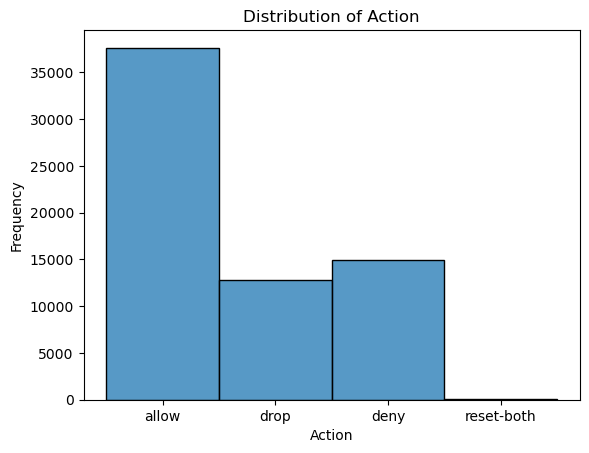

In [3]:
sns.histplot(data = df, x = 'Action') 
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Distribution of Action')
plt.show()


In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

le = LabelEncoder()
df['Action'] = le.fit_transform(df['Action'])
df

mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print('Mapping:\n', mapping)


Mapping:
 {'allow': 0, 'deny': 1, 'drop': 2, 'reset-both': 3}


In [5]:
columns_to_encode = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

df_encoded = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

df_encoded

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,177,94,83,2,30,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,4768,1600,3168,19,17,10,9,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,238,118,120,2,1199,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,3327,1438,1889,15,17,8,7,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,25358,6778,18580,31,16,13,18,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,314,192,122,6,15,4,2,False,False,...,False,False,False,False,False,False,False,False,False,False
65528,0,4680740,67312,4613428,4675,77,985,3690,False,False,...,False,False,False,False,False,False,False,False,False,False
65529,2,70,70,0,1,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
65530,2,70,70,0,1,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
df_encoded_numerical = df_encoded.apply(lambda col: col.astype(int))
df_encoded_numerical

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,177,94,83,2,30,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4768,1600,3168,19,17,10,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,238,118,120,2,1199,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3327,1438,1889,15,17,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,25358,6778,18580,31,16,13,18,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,314,192,122,6,15,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0
65528,0,4680740,67312,4613428,4675,77,985,3690,0,0,...,0,0,0,0,0,0,0,0,0,0
65529,2,70,70,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65530,2,70,70,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = df_encoded_numerical.drop(columns=['Action']) 
y = df_encoded_numerical['Action'] 

X_sparse = csr_matrix(X)

X_train, X_test, y_train, y_test = train_test_split(X_sparse, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    )

In [8]:
model = LinearSVC()

model.fit(X_train, y_train)

svm_predictions = model.predict(X_test)


In [9]:
svm_accuracy = accuracy_score(y_test, svm_predictions)
print('SVM Accuracy:', svm_accuracy)

In [10]:
print('SVM Classification Report:')
print(classification_report(y_test, svm_predictions))

In [11]:
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_conf_matrix

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, 
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = ['allow', 'deny', 'drop', 'reset-both'], 
            yticklabels = ['allow', 'deny', 'drop', 'reset-both'],
            cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [13]:
### testing CV

X = df_encoded_numerical.drop(columns=['Action']) 
y = df_encoded_numerical['Action'] 

X_sparse = csr_matrix(X)


model = LinearSVC()



SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37640
           1       1.00      1.00      1.00     14987
           2       1.00      1.00      1.00     12851
           3       0.00      0.00      0.00        54

    accuracy                           1.00     65532
   macro avg       0.75      0.75      0.75     65532
weighted avg       1.00      1.00      1.00     65532

SVM Confusion Matrix:
[[37607    33     0     0]
 [    8 14939    40     0]
 [    0     0 12851     0]
 [   12    42     0     0]]


In [14]:
cross_val_predictions = cross_val_predict(model, X_sparse, y, cv=5)

In [15]:
classification_rep = classification_report(y, cross_val_predictions)

scm_matrix = confusion_matrix(y, cross_val_predictions)

print('SVM Classification Report:')
print(classification_rep)

print('\n\n\nSVM Confusion Matrix:')
print(scm_matrix)

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37640
           1       0.99      1.00      1.00     14987
           2       1.00      1.00      1.00     12851
           3       0.00      0.00      0.00        54

    accuracy                           1.00     65532
   macro avg       0.75      0.75      0.75     65532
weighted avg       1.00      1.00      1.00     65532




SVM Confusion Matrix:
[[37604    36     0     0]
 [    8 14939    40     0]
 [    0     0 12851     0]
 [   12    42     0     0]]


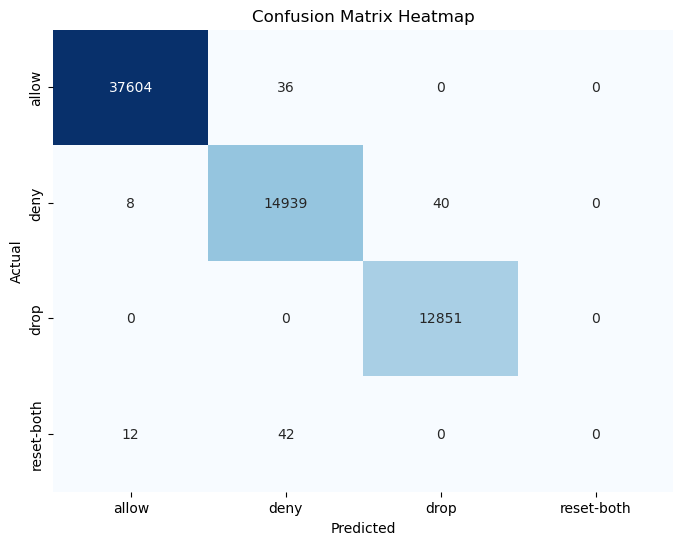

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(scm_matrix, 
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = ['allow', 'deny', 'drop', 'reset-both'], 
            yticklabels = ['allow', 'deny', 'drop', 'reset-both'],
            cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [8]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

model = LinearSVC()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']

best_model = LinearSVC(C=best_C)
best_model.fit(X_train, y_train)

svm_predictions = best_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_predictions)
print('Optimized SVM Accuracy:', svm_accuracy)

cross_val_predictions = cross_val_predict(best_model, X_train, y_train, cv=5)

classification_rep = classification_report(y_train, cross_val_predictions)

confusion_mat = confusion_matrix(y_train, cross_val_predictions)

print('Best C:', best_C)
print('SVM Classification Report:')
print(classification_rep)

print('\n\n\nSVM Confusion Matrix:')
print(confusion_mat)

Optimized SVM Accuracy: 0.9982452124818799
Best C: 10
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30095
           1       0.99      1.00      1.00     11993
           2       1.00      1.00      1.00     10289
           3       0.00      0.00      0.00        48

    accuracy                           1.00     52425
   macro avg       0.75      0.75      0.75     52425
weighted avg       1.00      1.00      1.00     52425




SVM Confusion Matrix:
[[30064    31     0     0]
 [    8 11952    33     0]
 [    0     0 10289     0]
 [    9    39     0     0]]


In [13]:
# change alpha & n_jobs
sgd_model = SGDClassifier(class_weight = 'balanced', early_stopping = ) # use early_stopping = True
sgd_model.fit(X_train, y_train)
sgd_predictions = sgd_model.predict(X_test)

In [14]:
sgd_accuracy = accuracy_score(y_test, sgd_predictions)
print('SGD Accuracy:', sgd_accuracy)

SGD Accuracy: 0.9900053406576639


In [15]:
print('SGD Classification Report:')
print(classification_report(y_test, sgd_predictions))

SGD Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7545
           1       1.00      1.00      1.00      2994
           2       0.96      1.00      0.98      2562
           3       0.00      0.00      0.00         6

    accuracy                           0.99     13107
   macro avg       0.74      0.75      0.74     13107
weighted avg       0.99      0.99      0.99     13107



In [16]:
sgd_conf_matrix = confusion_matrix(y_test, sgd_predictions)
sgd_conf_matrix

array([[7427,   11,  107,    0],
       [   0, 2987,    7,    0],
       [   0,    0, 2562,    0],
       [   3,    3,    0,    0]], dtype=int64)

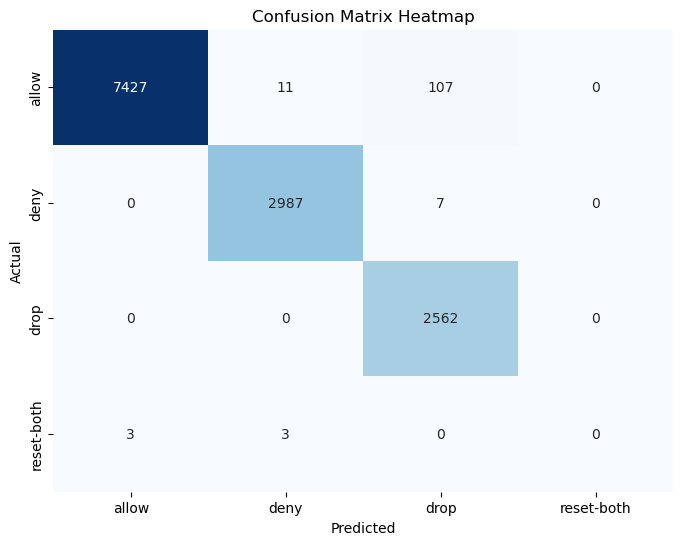

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(sgd_conf_matrix, 
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = ['allow', 'deny', 'drop', 'reset-both'], 
            yticklabels = ['allow', 'deny', 'drop', 'reset-both'],
            cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


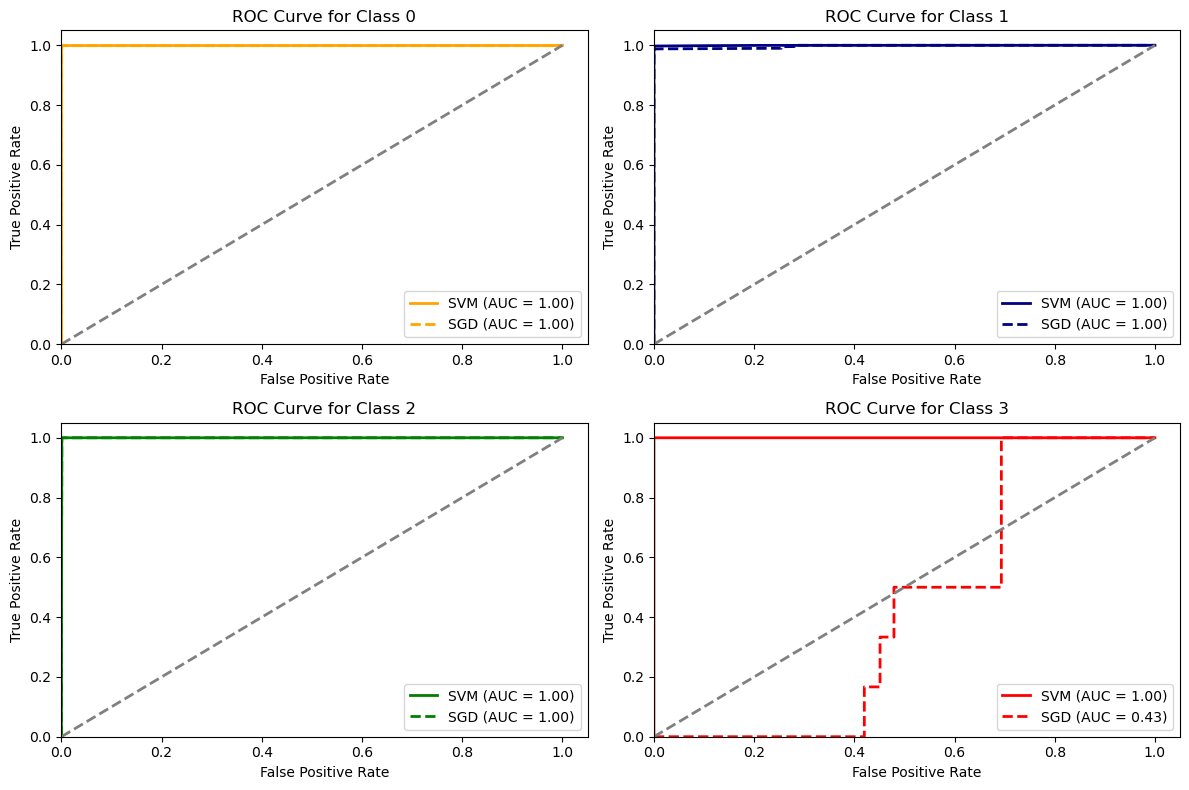

In [18]:
#### is auc a good way to view this??
#### i think so if split up like htis

y_test_binarized = label_binarize(y_test, classes = [0, 1, 2, 3])

svm_probs = model.decision_function(X_test)
sgd_probs = sgd_model.decision_function(X_test)

n_classes = 4
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

fpr_sgd = dict()
tpr_sgd = dict()
roc_auc_sgd = dict()

plt.figure(figsize=(12, 8))

colors = ['orange', 'navy', 'green', 'red']

for i in range(n_classes):
    plt.subplot(2, 2, i + 1)  
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_binarized[:, i], svm_probs[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])
    
    fpr_sgd[i], tpr_sgd[i], _ = roc_curve(y_test_binarized[:, i], sgd_probs[:, i])
    roc_auc_sgd[i] = auc(fpr_sgd[i], tpr_sgd[i])
    
    plt.plot(fpr_svm[i], 
             tpr_svm[i],
             color = colors[i],
             lw = 2,
             label = f'SVM (AUC = {roc_auc_svm[i]:.2f})')
    
    plt.plot(fpr_sgd[i],
             tpr_sgd[i],
             color = colors[i],
             linestyle = '--', 
             lw = 2,
             label = f'SGD (AUC = {roc_auc_sgd[i]:.2f})')
    
    plt.plot([0, 1], 
             [0, 1],
             color = 'gray', 
             lw = 2,
             linestyle = '--')
    
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()


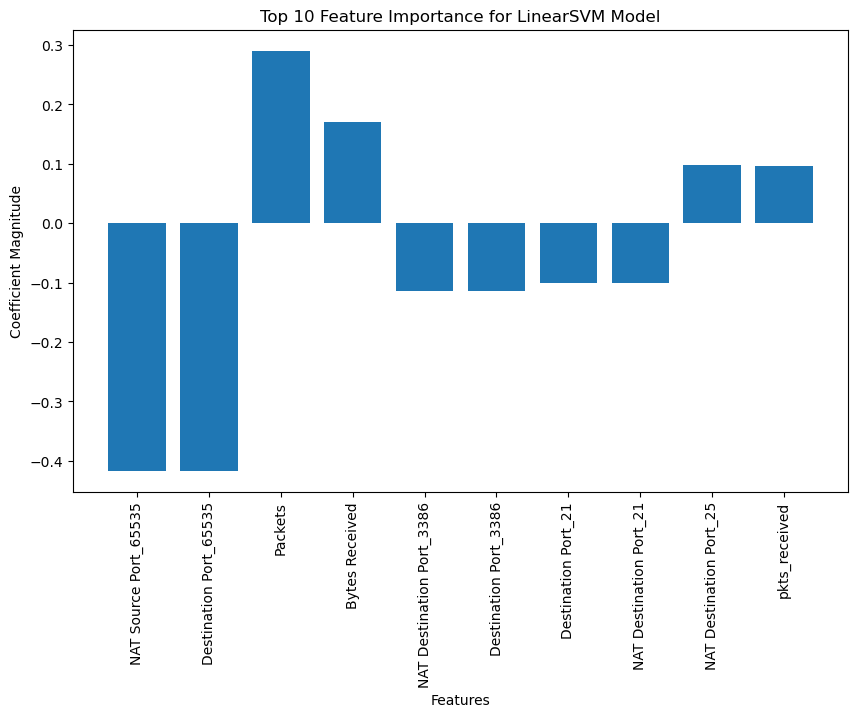

In [26]:
# Multiple websites were used.. this was a big help
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

coefficients = model.coef_[0]

feature_names = df_encoded_numerical.columns


non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefficients = coefficients[non_zero_indices]

sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1][:10]
top_coefficients = non_zero_coefficients[sorted_indices]
top_feature_indices = non_zero_indices[sorted_indices]

top_feature_names = [feature_names[i] for i in top_feature_indices]

plt.figure(figsize = (10, 6))
plt.bar(range(len(top_feature_names)), 
        top_coefficients, 
        tick_label = top_feature_names)

plt.title('Top 10 Feature Importance for LinearSVM Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')

plt.xticks(rotation = 90)

plt.show()

In [25]:
top_feature_names

['NAT Source Port_65535',
 'Destination Port_65535',
 'Packets',
 'Bytes Received',
 'NAT Destination Port_3386',
 'Destination Port_3386',
 'Destination Port_21',
 'NAT Destination Port_21',
 'NAT Destination Port_25',
 'pkts_received']

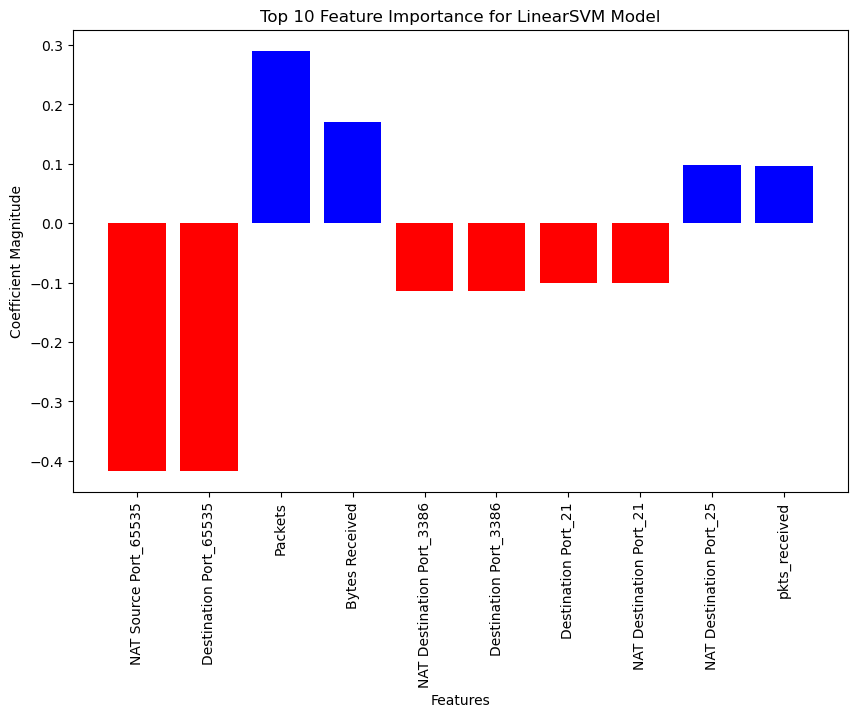

In [27]:
coefficients = model.coef_[0]

non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefficients = coefficients[non_zero_indices]

sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1][:10]
top_coefficients = non_zero_coefficients[sorted_indices]
top_feature_indices = non_zero_indices[sorted_indices]

top_feature_names = [feature_names[i] for i in top_feature_indices]

bar_colors = ['red' if coeff < 0 else 'blue' for coeff in top_coefficients]

plt.figure(figsize = (10, 6))

plt.bar(range(len(top_feature_names)), 
        top_coefficients,
        tick_label = top_feature_names,
        color = bar_colors)

plt.title('Top 10 Feature Importance for LinearSVM Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')

plt.xticks(rotation = 90)


plt.show()

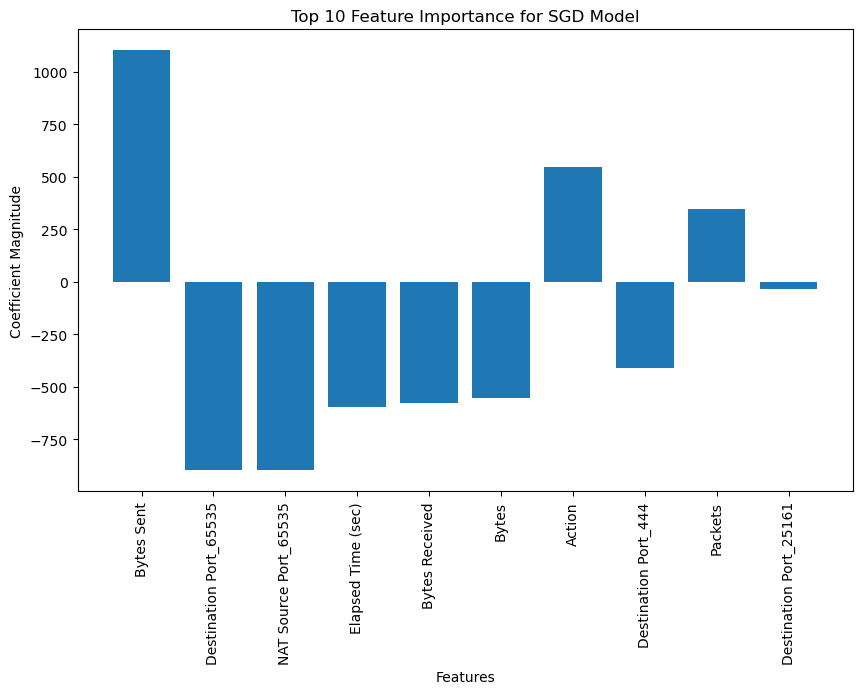

In [28]:
coefficients = sgd_model.coef_[0]

your_feature_names = df_encoded_numerical.columns


non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefficients = coefficients[non_zero_indices]

sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1][:10]
top_coefficients = non_zero_coefficients[sorted_indices]
top_feature_indices = non_zero_indices[sorted_indices]

top_feature_names = [feature_names[i] for i in top_feature_indices]

plt.figure(figsize = (10, 6))
plt.bar(range(len(top_feature_names)), 
        top_coefficients, 
        tick_label = top_feature_names)

plt.title('Top 10 Feature Importance for SGD Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')

plt.xticks(rotation = 90)

plt.show()

In [29]:
top_feature_names

['Bytes Sent',
 'Destination Port_65535',
 'NAT Source Port_65535',
 'Elapsed Time (sec)',
 'Bytes Received',
 'Bytes',
 'Action',
 'Destination Port_444',
 'Packets',
 'Destination Port_25161']

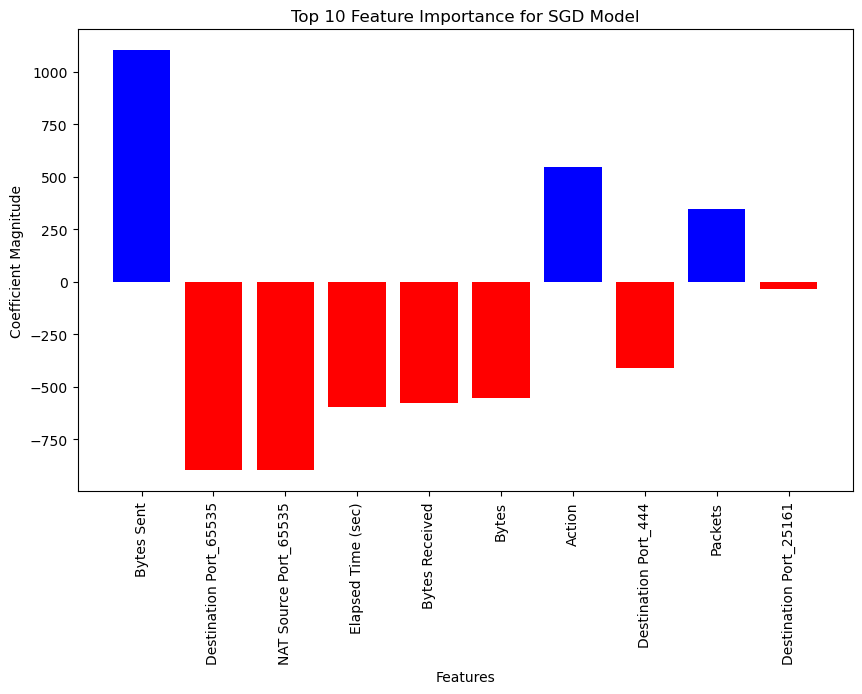

In [22]:
coefficients = sgd_model.coef_[0]

non_zero_indices = np.where(coefficients != 0)[0]
non_zero_coefficients = coefficients[non_zero_indices]

sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1][:10]
top_coefficients = non_zero_coefficients[sorted_indices]
top_feature_indices = non_zero_indices[sorted_indices]

top_feature_names = [feature_names[i] for i in top_feature_indices]

bar_colors = ['red' if coeff < 0 else 'blue' for coeff in top_coefficients]

plt.figure(figsize = (10, 6))

plt.bar(range(len(top_feature_names)), 
        top_coefficients,
        tick_label = top_feature_names,
        color = bar_colors)

plt.title('Top 10 Feature Importance for SGD Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')

plt.xticks(rotation = 90)


plt.show()